# **Statistics lecture 5 Hands-on session : solutions notebook**

This is the companion notebook to lecture 4 in the statistical course series, covering the following topics:
1. Parameter estimation using simple tools
2. Parameter estimation using the profile likelihood
3. Limit-setting, using simple tools
4. Limit-setting using the profile likelihood

First perform the usual imports:

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

## 1. Profiling basics

In the previous lectures, we have discussed 3 types of statistical results:
* Testing for discovery
* Computing confidence intervals for parameters (central value +/- uncertainty)
* Setting upper limits

For simplicity, all this was done using models with only 1 parameter (the signal $s$), which was the *parameter of interest*. Models usually also have additional *nuisance parameters* which aren't interesting in themselves, but need to be included to describe the data.

These parameters need to be included in the treatment, but fortunately this is quite easy in the likelihood ratio framework. The basic quantity we used before was
$$
t(s) = -2 \log \frac{L(s)}{L(\hat{s})}
$$

This allows to compare 2 hypotheses:
* The free hypothesis $\hat{s}$ which corresponds to the best-fit $s$ in the data.
* The fixed hypothesis $s$ (for instance $s=0$ for discoveries)

If we have an additional nuisance parameter $\theta$, the likelihood is now a function of both parameters: $L(s, \theta)$. How do we set $\theta$ ? The interesting answer is that in both cases, we use the best-fit value of $\theta$ :
* For the free hypothesis $\hat{s}$, we use $\hat{\theta}$, the best-fit value of $\theta$.
* For the fixed hypothesis $s$, we use $\hat{\hat{\theta}}(s)$, the best-fit value of $\theta$ at a fixed $s$.

So in the end we use
$$
t(s) = -2 \log \frac{L(s, \hat{\hat{\theta}}(s))}{L(\hat{s},\hat{\theta})}
$$
with the appropriate best-fit values. This is now called the *profile likelihood*.

A very nice feature of this is that $t(s)$ is still a function only of $s$, so we can perform the rest of the computation in the same way as before. The only difference is that we need to compute best-fit values for $\theta$ in order to compute the appropriate ilikelihood values.


## 1. Profiling on a single-bin example

We reuse the same examples as in the previous sections: the full binned example defined below:

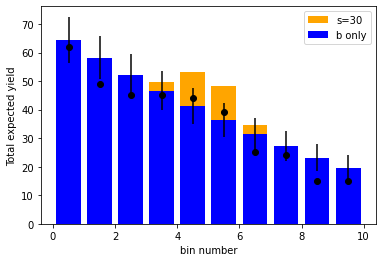

In [2]:
nbins = 10
x = np.linspace(0.5, nbins - 0.5, nbins)
# The background follows a linear shape
b_yields = np.array([ (1 - i/2/nbins) for i in range(0, nbins) ])
b_yields *= b_yields/np.sum(b_yields)
# The signal shape is a peak
s_yields = np.zeros(nbins)
s_yields[3:7] = [ 0.1, 0.4, 0.4, 0.1 ]
# Now generate some data
s = 10
b = 500
s_and_b = s*s_yields + b*b_yields
b_only = b*b_yields
np.random.seed(1) # make sure we always generate the same
data = [ np.random.poisson(s*s_yield + b*b_yield) for s_yield, b_yield in zip(s_yields, b_yields) ]
s30_and_b = 30*s_yields + b*b_yields
plt.bar(x, s30_and_b, color='orange', label='s=30')
plt.bar(x, b_only, color='b', yerr=np.sqrt(b_only), label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

and also the single-bin measurement in bin 4:

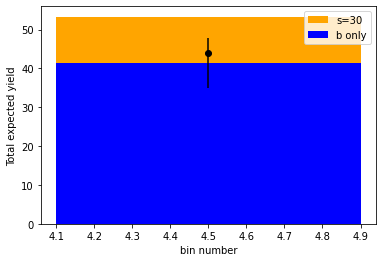

In [3]:
sb4 = s30_and_b[4]
b4 = b_only[4]
n4 = data[4]
plt.bar(x[4], sb4, color='orange', label='s=30')
plt.bar(x[4], b4, color='b', yerr=np.sqrt(b_only[4]), label='b only')
plt.scatter(x[4], n4, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

We introduce a new ingredient: the background level $b_4$ is now not a fixed number, but only known up to an uncertainty, say $\sigma_b = \pm 2$. We assume here that it is Gaussian-distributed, so that the full likelihood is
$$
L(s, b) = P(n_4; s_4 + b_4) G(b^{\text{aux}}, b_4, \sigma_b)
$$

where the first term is the Poisson PDF we had before, and the Gaussian is a new term giving the PDF for $b_4$. The central value of the $b_4$ constraint is $b^{\text{aux}}$, which is a kind of observable: we can assume that our knowledge of $b_4$ comes from a separate "auxiliary" experiment which observed $b^{\text{aux}}$ with an uncertainty $\sigma_b$, and we use this to constrain $b_4$ in the experiment here. 

In practice the constraint on $b_4$ can also come from Monte-Carlo simulation, an independent theory prediction, etc., but in this case we can anyway use the same formalism, and set $b^{\text{aux}}$ to the nominal prediction and $\sigma_b$ to its uncertainty.

Here we'll set $b^{\text{aux}}$ to our original background value, which is what we take as nominal:

In [4]:
baux = b_only[4]
sigmab = 3

Now we compute the profile likelihood, with $s$ as our parameter of interest, and $b$ the nuisance parameter. 

First we define $\lambda(s,b) = -2\log L(s,b)$, where $L(s,b)$ is the product of two terms:
* The usual Poisson PDF for the one-bin counting process
* The Gaussian representing the constraint on $b$, with an observable $b_{\text{aux}}$, a mean $b$, and a width $\sigma_b$.

Secondly, we define the *profiled* version of the above, where $b$ is set to its best-fit value. To define it, we first must compute the best-fit $\hat{\hat {b}}(s)$ for a given $s$, by minimizing $\lambda(s,b)$ for a fixed value of $s$. Then the profile likelihood is defined as $\lambda(s) = -2\log L(s,\hat{\hat {b}}(s))$.

Finally, the $t(s)$ function is defined as usual as $t(s) = \lambda(s) - \lambda(\hat{s})$, after computing the best-fit $\hat{s}$ which minimizes $\lambda(s)$. 


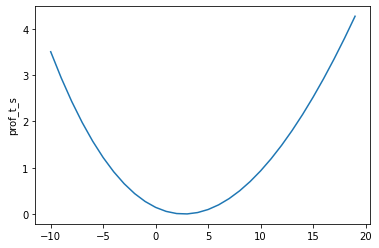

In [5]:
def logL_sb(s_val,b_val) : 
   return -2*np.log(scipy.stats.poisson.pmf(n4, s_val+b_val)*scipy.stats.norm.pdf(baux, b_val, sigmab))

def prof_logL_s(s_val) :
    best_fit_b = scipy.optimize.minimize_scalar(lambda b_val : logL_sb(s_val,b_val), bracket=(30,50)).x
    return logL_sb(s_val, best_fit_b)

def prof_t_s(s_val) :
    best_fit_s = scipy.optimize.minimize_scalar(prof_logL_s, bracket=(-10,20)).x
    return prof_logL_s(s_val) - prof_logL_s(best_fit_s)
    
s_vals = np.arange(-10,20,1)
plt.plot(s_vals, [ prof_t_s(s_val) for s_val in s_vals ])

plt.ylabel('prof_t_s');

This looks quite familiar from our previous exercises: we can extract the best-fit value of $s$ from the minimum value, and the uncertainties from the crossings with $t=1$. Just to check, we can compare with what we would get if we took a fixed background as before: 

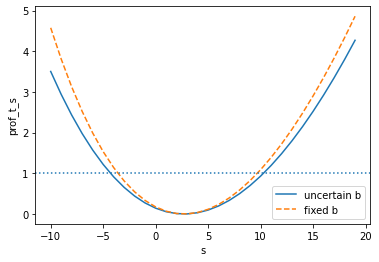

In [6]:
def t_sb(s, b) :
    best_fit_s = scipy.optimize.minimize_scalar(lambda s : logL_sb(s, b), bracket=(-10,20)).x
    return logL_sb(s, b) - logL_sb(best_fit_s, b)
    
s_vals = np.arange(-10,20,1)
plt.plot(s_vals, [ prof_t_s(s_val) for s_val in s_vals ], label='uncertain b')
plt.plot(s_vals, [ t_sb(s_val, b4) for s_val in s_vals ], linestyle='--', label='fixed b')
plt.xlabel('s')
plt.ylabel('prof_t_s')
plt.axhline(1, linestyle=':')
plt.legend();

So everything works as expected : we get the same result as before, but the size of the confidence interval went up since now the background adds a new source of uncertainty. As before, we could compute the crossings with $t=1$ to get the precise values of the uncertainties in each case.

To see a bit better what is happening, we can check the values of the best-fit $b$ for different $s$ values:

In [7]:
print('b4 = ', b4)
print('best_fit_b (2.7) =', scipy.optimize.minimize_scalar(lambda b : logL_sb(s_val=2.7,b_val=b), bracket=(30,50)).x)
print('best_fit_b (-10) =', scipy.optimize.minimize_scalar(lambda b : logL_sb(s_val=-10,b_val=b), bracket=(30,50)).x)
print('best_fit_b (20) =', scipy.optimize.minimize_scalar(lambda b : logL_sb(s_val=20,b_val=b), bracket=(30,50)).x)

b4 =  41.29032258064516
best_fit_b (2.7) = 41.291965557358836
best_fit_b (-10) = 43.953375189052714
best_fit_b (20) = 39.00196361278273


At the best-fit point $s=2.7$, the best-fit background is the nominal one. However if we take a lower $s$ value $s=-10$, we get a higher best-fit $b$. And if we push $s$ up, $b$ goes down. What happens is that $b$ is adjusting to $s$, and partially compensating for the the fact that these values of $s$ don't quite agree with the data. This extra adjustment makes it more difficult to exclude values of $s$ away from $\hat{s}$, so that the allowed range of $s$ gets larger -- and therefore the uncertainties get larger as well.

## 3. Profiling the multi-bin example

In the single-bin example, we could only release $b$ if we also introduced an external constraint in the measurement. This is because the single-bin example only measures one number, so it cannot be used to determine both $s$ and $b$.

In multi-bin analyses, we count events in multiple bins so it is possible to simultaneously measure multiple parameters. In our example, we can measure $s$ in the central, signal-rich region, while extracting $b$ from the side regions where there is no signal.

So we can keep the same likelihood definition as in the previous lecture (without the Gaussian term) and simply make $b$ a free (nuisance) parameter.

<ipython-input-8-ef7d8282d5ff>:4: RuntimeWarning: divide by zero encountered in log
  return -2*sum( [ np.log(scipy.stats.poisson.pmf(n, s_val*s_yield + b_val*b_yield)) for n, s_yield, b_yield in zip(data, s_yields, b_yields) ] )
/home/nberger/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2522: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


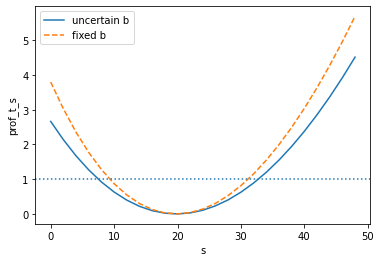

In [8]:
s_vals = np.arange(0,50,2)

def logL_sb(s_val, b_val) :
    return -2*sum( [ np.log(scipy.stats.poisson.pmf(n, s_val*s_yield + b_val*b_yield)) for n, s_yield, b_yield in zip(data, s_yields, b_yields) ] )

def prof_logL_s(s_val) :
    best_fit_b = scipy.optimize.minimize_scalar(lambda b_val : logL_sb(s_val,b_val), bounds=(100,1000)).x
    return logL_sb(s_val, best_fit_b)

def prof_t_s(s_val) :
    best_fit_s = scipy.optimize.minimize_scalar(prof_logL_s, bounds=(0,50)).x
    return prof_logL_s(s_val) - prof_logL_s(best_fit_s)

def t_sb(s_val, b_val) :
    best_fit_s = scipy.optimize.minimize_scalar(lambda s_val : logL_sb(s_val, b_val), bounds=(0,50)).x
    return logL_sb(s_val, b_val) - logL_sb(best_fit_s, b_val)

plt.plot(s_vals, [ prof_t_s(s_val) for s_val in s_vals ], label='uncertain b')
plt.plot(s_vals, [ t_sb(s_val, b_val=428) for s_val in s_vals ], linestyle='--', label='fixed b')
plt.xlabel('s')
plt.ylabel('prof_t_s')
plt.axhline(1, linestyle=':')
plt.legend();

So it works as before (just ignore the warning!). Note that the central value is also shifted: the best-fit $b$ is now different from the one we had fixed before ($b=428$ instead of our assumed $b=500$), so the signal also gets a different value. 

This illustrates an important advantage of models with nuisance parameters: since the parameters adapt to the data, they can avoid biases in the results coming from faulty assumptions -- the results are therefore more reliable.

## 4. Bayesian methods: simple case

The methods we have seen so far are *frequentist*. This in effect means that there are 2 difference classes of parameters
* Observables, which are randomly given by the experiment.
* Parameters, which always have a unique, fixed value -- which is known, or more often unknown.

There is another class of methods, *Bayesian* methods, which have a different take on measurement. In this approach, everything is random:
* Observables are random as before
* Parameters are also considered random, with the associated PDF used to quantify the uncertainty on their values.

So for instance, for a Gaussian measurement:
* The frequentist approach is to say $s = 2 +/- 3$, meaning that the interval $[-1, 5]$ has a 68% chance of containing the true value of $s$
* The Bayesian approach is to say that $s \sim G(2, 3)$, where the Gaussian encodes the same information.

One thing to note is that in the frequentist setting, "$[-1, 5]$ has a 68% chance of containing the true value of $s$" is a statement on the interval itself, which is defined for a given experiment: another experiment would find another interval, and 68% of these intervals are guaranteed to contain the true value. For the Bayesian approach, the value of $s$ is itself random, and the experiment is just a way to gather more information on its distribution.

The fundamental tool of Bayesian inference is Bayes' theorem. It can be written as
$$
P(s) \propto L(s; n) \pi(s)
$$
where 
* $\pi(s)$ is the *prior* PDF -- a PDF giving the knowledge of $s$ that we had before the experiment
* $L(s;n)$ is the usual likelihood
* $P(s)$ is the *posterior* PDF on $s$, i.e. the distribution that encodes our knowledge of $s$ including the experimental information.

A limit on $s$ can then be set by integrating the posterior $P(s)$ and finding $s_{up}$ so that $\int^{s_{up}} P(s) ds = 95\%$.

Consider the example we had before:

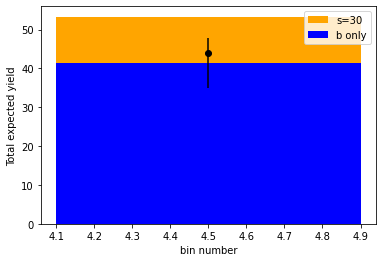

In [9]:
plt.bar(x[4], sb4, color='orange', label='s=30')
plt.bar(x[4], b4, color='b', yerr=np.sqrt(b_only[4]), label='b only')
plt.scatter(x[4], n4, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

and assume we have a flat prior on $s$, $\pi(s) = k$. Flat priors are often used in Bayesian applications, since they provide a relatively unbiased starting point.
(Note that technically the flat distribution is not well defined if the range of $s$ is infinite, but this won't crea te problems here).

Now we can derive the upper limit:

Bayesian limit = 15.282698778072337


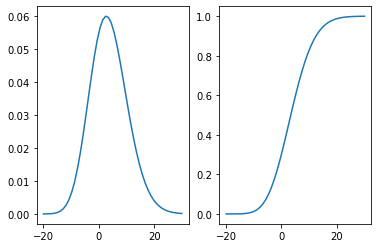

In [10]:
def p_s(s_val) :
  return scipy.stats.poisson.pmf(n4, s_val + b4)

import scipy.integrate

def integral_s(s_val) :
    return scipy.integrate.quad(p_s, -20, s_val)[0]

s_vals = np.linspace(-20,30,50)
plt.subplot(121)
plt.plot(s_vals, [ p_s(s_val) for s_val in s_vals ])
plt.subplot(122)
plt.plot(s_vals, [ integral_s(s_val) for s_val in s_vals ])
s_limit = scipy.optimize.root_scalar(lambda s : integral_s(s) - 0.95, bracket=[0, 30]).root
print('Bayesian limit =', s_limit);

## 4. Bayesian methods: nuisance parameters

Models usually also include nuisance parameters. For instance we considered a one-bin model where the background was only defined up to an uncertainty, so that the full likelihood is
$$
L(s, b) = P(n_4; s_4 + b_4) G(b^{\text{aux}}, b_4, \sigma_b)
$$

The way to treat this in a Bayesian way is to integrate over the nuisance parameters: formally
$$
P(s) \propto \int L(s, b; n) \pi(s) G(b) db
$$
So that the constraint becomes the prior PDF of $b$. Using an uncertainty of $5$ on the background, and a central value equal to $b_4$, we have

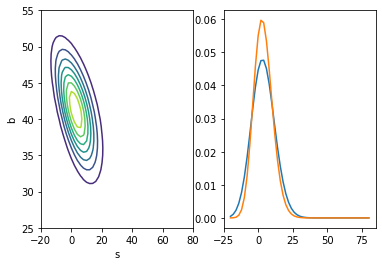

In [15]:
def p_sb(s_val, b_val) :
  return scipy.stats.poisson.pmf(n4, s_val + b_val)*scipy.stats.norm.pdf(b_val, loc=b4, scale=5)

def integral_intb(s_val) :
    return scipy.integrate.quad(lambda b : p_sb(s_val, b), 25, 55)[0]

def integral_sb(s_val) :
    return scipy.integrate.quad(integral_intb, -25, s_val)[0]

s_vals = np.linspace(-20,80,51)
b_vals = np.linspace(25,55,31)
s_mesh,b_mesh = np.meshgrid(s_vals, b_vals)
plt.subplot(121)
plt.contour(s_mesh, b_mesh, p_sb(s_mesh, b_mesh) )
plt.xlabel('s')
plt.ylabel('b')
plt.subplot(122)
plt.plot(s_vals, [ integral_intb(s_val) for s_val in s_vals ], label='marginalized b')
plt.plot(s_vals, [ p_s(s_val) for s_val in s_vals ], label='fixed b');

Bayesian limit = 18.12048588801174


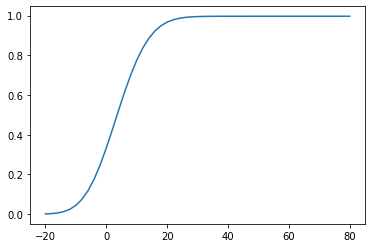

In [14]:
plt.plot(s_vals, [ integral_sb(s_val) for s_val in s_vals ]);
s_limit = scipy.optimize.root_scalar(lambda s : integral_sb(s) - 0.95, bracket=[0, 50]).root
print('Bayesian limit =', s_limit)

As expected, the limit is slightly larger than in the no-systematics case.